# Vasicek Model: Parameter estimation and Visualization

This JupyterNotebook is aimed to replace an additional pdf report since we feel that a lot of explanaitions would overlap and a JupyterNotebook is convenient to work with especially considering the inline plots and the REPL characteristics. We structure this notebook in the following way:

<ol style="font-family: 'Times New Roman', serif; margin-left: 1.2em;font-size: 18px;">
  <li>
    Introduction and Problem Statement / Methodology
    <ol>
      <li>Ornstein-Uhlenbeck process properties</li>
      <li>MLE estimation</li>
    </ol>
  </li>

  <li>
    Implementation
    <ol>
      <li>Data Preparation</li>
      <li>MLE Implementation</li>
      <li>Process Simulation</li>
    </ol>
  </li>

  <li>
      Visualization
      <ol>
      <li>Random Trajectories</li>
      <li>Deterministic vs History</li>
      <li>Simulation vs History</li>
    </ol>
  </li>
  <li>Further Remarks and possible Improvements</li>
</ol>



## Introduction and Problem Statement

This project implements and explores the __Vasicek model__ , a stochastic model to model short-term interest rates. Mathematically speaking, it is a __Ornsteil-Uhlenbeck process__ which captures empirical observations made for short-term interest rates, i.e. a drift towards an equilibrium in the long run and a mean-reverting behaviour which it is wandering around in a stochastic manner. This model is often used in bond pricing, risk management and term structure modeling.

It has been introduced in the original article __Vasicek, Oldrich "An equilibrium characterization of the term structure." Journal of financial economics 5.2 (1977): 177-188__ which will be our main reference for the underlying model during this assignment.
The vasicek model is a model for 
simulating interest rates and it is often used because of the mean-reverting properties. In general, for parameters $a,b,\sigma \in \mathbb{R}$ and $T<\infty$ the model dynamics are described by an Ornstein-Uhlenbeck process:
$$ dr_t = a(b-r_t)dt + \sigma dW_t \quad , t \in [0,T]$$

where $W_t$ is a standard Wiener process/Brownian Motion. The parameter effects can be summarized by noting

<ul style="font-family: 'Times New Roman', serif; margin-left: 1.2em;">
  <li> $b \in \mathbb{R}$  , the long term mean (the drift component is attracted to this parameter)</li>
  <li> $a > 0$, the speed/rate at which the mean reversion happens</li>
  <li> $\sigma > 0$, the instantaneous volatility (or the "amount of noise").</li>
</ul>


We will not explain the procedure of solving this equation and the underlying theory since this is out of scope of this assignment. The necessary theory for Ito calculus and SDE solutions can be found in __Karatzas, Ioannis, and Steven Shreve  Brownian motion and stochastic calculus springer, 2014__. 

To calibrate this model for a chosen scenario, we have to find real world data. We need tim-series data for short-term interest rates of different kinds. 
We will choose dataset(s) from the Federal Reserve Bank of St. Luis namely the 

__Secured Overnight Financing Rate (SOFR)__:

https://fred.stlouisfed.org/series/SOFR

__Federal Funds effective Rate (DFF)__:

https://fred.stlouisfed.org/series/DFF

for the timespan of 2000-01-01 until 2024-12-31 (the SOFR is only available since 2018 but more on that later on). These datasets will be in the <u><code>data</code></u> folder as <u><code>csv</code></u> data. More detailed descriptions can be found on the websites themselves but both can be seen as short-term interest rates that can be used to calibrate our model. 

To begin with, we will describe some Properties about the stochastic process that results in this model.

### Ornstein-Uhlenbeck process properties

The Ornstein-Uhlenbeck (**OU**) process has a solution of the form

$$r_t = r_0 e^{-at} + b(1-e^{-at}) + \sigma e^{-at}\int_{0}^{t}e^{as}dW_s \; .$$

A very useful fact (that we will not prove but can be proven by comparing characteristic/moment generating function as they uniquely define the entire distribution) is that 

$$ \int_{0}^{t}f(s)dW_s \sim \mathcal{N}\left(0,\int_{0}^{t}f(s)^2ds\right) \; .$$

We therefore obtain by integral computations that $r_t$ has a normal distribution with

$$ r_t \sim \mathcal{N}\left(r_0 e^{-at} + b(1-e^{-at}) \;, \; \frac{\sigma^2}{2a}(1-e^{-2at}) \right)\quad .$$

By using the so called **Flow** property of strong SDE solutions, we can even start this process at time $s$ instead of $0$ and obtain as a conditional distribution:

$$ r_t | r_s \sim \mathcal{N}\left(r_s e^{-a(t-s)} + b(1-e^{-a(t-s)}) \;, \; \frac{\sigma^2}{2a}(1-e^{-2a(t-s)}) \right) \quad .$$

If we now use an equally distanced discretization $\{t_1,\dots,t_n \; | \; \text{  s.t.  } \; t_{i+1}-t_i = \frac{T}{n}  =: \Delta t \} $ for $[0,T]$ and observe realizations of $(r_t)_{ 0\leq t \leq T}$ at times $t_i$ we obtain by the previous observation:

$$ r_{t_{i+1}} | r_{t_{i}} \sim \mathcal{N}\left(r_s e^{-a\Delta t} + b(1-e^{-a\Delta t}) \;, \; \frac{\sigma^2}{2a}(1-e^{-2a\Delta t}) \right) \quad .$$

This shows that this conditional distribution only cares about the distance in time, not the exact point in time as it only depends on $\Delta t$. This allows us to use a series of real world observations of $r_t$ and fit a Normal Distribution with **constant** mean and variance. This makes it much simpler in the future, as other discretizations would not produce constant mean and variance. Note that this is only obtained because of the nice structure the solution of this very specific SDE has, solutions to more complex SDE's might not offer a similar result.

### Maximum Likelihood Estimator

 We will focus on the case of having a conditional density function $f(x|y \; ;\theta) $ with $\theta \in \Theta$ being the parameters we want to estimate. We assume to have $n$ iid samples $x_1, \dots, x_n$ that we assume to be distributed according to our density function, i.e. being produced by our underlying model. The MLE is the parameter $\hat{\theta}_{\text{MLE}}$ that maximizes the likelihood function

$$L(\theta) = \prod_{i=1}^{n}f(x_i|x_{i-1}\; ; \theta) \; .$$

This term however is numerically unstable as it is prone to either be extremely small or large due to chain multiplication. It is common practice to therefore apply a strictly monotonous function that makes the likelihood function easier to handle, mostly the $log$ function since it transforms the product into a sum:

$$ \log L(\theta) = \sum_{i=1}^{n}\log f(x_i|x_{i-1}\; ; \theta) \; .$$

Often times instead of maximizing this term one instead minimizes the negative log-likelihood function which is obviously equivalent.
In our case we know the conditional density $f$ since we just saw that our increments are distributed according to a normal distribution.
We want to estimate $a,b, \sigma$ which means we can set $\theta = (a,b,\sigma)$.
This means we can explicitly calculate its logarithm

$$ \log f(x_i|x_{i-1}\; ; a,b,\sigma) = -\frac{1}{2}\log(2\pi \nu) - \frac{(x_i - \mu_{i-1})^2}{2\nu}$$
with 
$$ \nu = \frac{\sigma^2}{2a}(1-e^{-2a\Delta t}) \quad \text{and} \quad \mu_{i-1} = x_{i-1} e^{-a\Delta t} + b(1-e^{-a\Delta t}) \; .$$

We can define the log-likelihood function now as a function in Python as well with corresponding inputs. The goal is to minimize it's output using Pythons <u><code>scipy</code></u> package. This will be implemented and explained further after the preparation of the data already mentioned.

## Implementation

### Data cleaning/Preparation

After downloading the csv data, we have to make sure that it has the correct format and does not contain problematic or wildly unrealistic values. For this purpose we will read in the csv data using the <u><code>pandas</code></u> package which is a package inteded for efficient data analysis and useful data structures, such as <u><code>pandas.DataFrame</code><u>.

In [3]:
# Import pandas using a common alias:
import pandas as pd

# Use pandas method to read in data and convert it to pandas.DataFrame structure:
df_DFF = pd.read_csv(filepath_or_buffer="../data/raw/DFF.csv")

# Check type of df_DFF
print(f"The datatype of df_DFF is : {type(df_DFF)} \n")

# Drop 'NA' values --> delete rows where there is no data using the dropna method for DataFrames:
# inplace is an input that if set to True does the same as:
# ' df_DFF = df_DFF.dropna()'
df_DFF.dropna(inplace=True) 

# Take a look at some values using the .head(n=*) method to look at the top n rows:
print(df_DFF.head(n=10))

The datatype of df_DFF is : <class 'pandas.core.frame.DataFrame'> 

  observation_date   DFF
0       2000-01-01  3.99
1       2000-01-02  3.99
2       2000-01-03  5.43
3       2000-01-04  5.38
4       2000-01-05  5.41
5       2000-01-06  5.54
6       2000-01-07  5.61
7       2000-01-08  5.61
8       2000-01-09  5.61
9       2000-01-10  5.74


We can see that this DataFrame consists of 2 columns and an Index set. We will store the names of these columns for further usage and convert the first column storing the observation dates to pandas datetime format. This is a format that has valuable functionalities for dates such as comparing dates, shifting them and adding or subtracting years,dates or even just seconds if needed.

Most notably, the values we are most interested in are given in percentages. For further usage we want these values to actually be in regular floating point format.

In [4]:
# df.columns returns an array containing the column names as strings:
date_col = df_DFF.columns[0]
rates_col = df_DFF.columns[1]

#convert from string to datetime object
df_DFF[date_col] = pd.to_datetime(df_DFF[date_col])

# make sure the data types are as we would want them using pandas.DataFrame.dtypes attribute
print(f"The datatypes for each column in the df_DFF DataFrame are: \n {df_DFF.dtypes} \n")

The datatypes for each column in the df_DFF DataFrame are: 
 observation_date    datetime64[ns]
DFF                        float64
dtype: object 



We now have converted the dates into a format that we can work with better. We now have to make sure that we are not missing any dates, especially business dates as in that case we would have a misrepresentation resulting in implicit errors of our model and it's representational power.

For that we extract the earliest (min) and latest (max) date where we immediately make use of the datetime format. We then use <u><code>pandas.bdate_range</code></u> to create an array of datetime values for every businessday between the min date and the max date. We then set these dates as new Index and give them a new name.

In [5]:
# Extract min and max date
min_date , max_date = df_DFF[date_col].min(), df_DFF[date_col].max()

# Create business day DatetimeIndex object to reindex existing data:
b_days = pd.bdate_range(start=min_date, end=max_date)

# Delete date_col:
# df.drop(columns="observation_date", inplace=True)

# reindex
df_DFF.set_index(keys=date_col,inplace=True)

# for dates that have not existed before we take the previous days short rate --> ffill = forward fill
df_DFF = df_DFF.reindex(b_days, method="ffill")
df_DFF.index.name = "date"

print(df_DFF.head(n=10))

             DFF
date            
2000-01-03  5.43
2000-01-04  5.38
2000-01-05  5.41
2000-01-06  5.54
2000-01-07  5.61
2000-01-10  5.74
2000-01-11  5.63
2000-01-12  5.59
2000-01-13  5.58
2000-01-14  5.56


We now observe that the actual interest rate values are given in percentages. We would rather work actual "normal" format floating point numbers to avoid confusion later on so we convert this column by dividing it with 100.

Afterwards we will rename that column and save the resulting DataFrame to a csv using corresponding methods that can be found in the official documentation as well.

In [6]:
# As we saw that the DGS10 values are given in percentage values, we want 

## to convert them to their "proper" values:
df_DFF[rates_col] /= 100.0

#Round to 4 decimal places
df_DFF[rates_col] = df_DFF[rates_col].round(4)

# Rename DGS10 column for convenience
df_DFF.rename(columns={"DFF": "rate_pct"}, inplace=True)

Let's take a look at the data we have! It is a timeseries which is easy to visualize using well known functionalities from <u><code>matplotlib.pyplot</code></u>.

In [7]:
# We import matplotlib.pyplot, a well known library for visualization purposes
# We specifically use the .pyplot API as described in the documentation as more complex figures are not needed yet.
import matplotlib.pyplot as plt

# This line is specifically needed for jupyter notebooks to show the plots underneath each Code cell. In .py this will not be used.
%matplotlib inline

In [8]:
df_DFF.head()

,rate_pct
date,
2000-01-03,0.0543
2000-01-04,0.0538
2000-01-05,0.0541
2000-01-06,0.0554
2000-01-07,0.0561


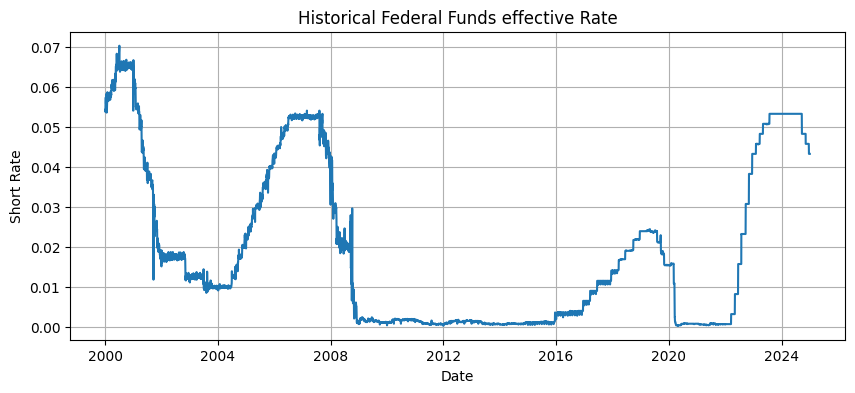

In [9]:
# Create a new matplotlib.pyplot figure, figsize gives the x and y axis size 
plt.figure(figsize=(10, 4))

# Tell matplotlib what data should be fed in to the created figure (if plt.figure was not specified this would create a figure alternatively)
plt.plot(df_DFF.index, df_DFF["rate_pct"], label="Historical Federal Funds effective Rate")

# Display a grid for better overview
plt.grid()

# Give the figure x and y axis labels
plt.xlabel("Date")
plt.ylabel("Short Rate")

# Define the title
plt.title("Historical Federal Funds effective Rate")

# Display the figure object
plt.show()

In [10]:
# Save the DFF Dataset:
df_DFF.to_csv(path_or_buf="../data/processed/DFF_clean.csv")

This plot clearly shows much higher activity of the short rate before the year 2018 than after. This is the case because we likely added a lot of business days for which there was no data after which we applied the forward fill to close these data gaps. Since there seems to be quite a large amount of artificially added data points after using ffill when reindexing, it should be concidered to use a shorter range of dates as we do not want to have too much wrong data, the forward fill was just a method to close data gaps. For the sake of having enough meaningful data (and further exploring pandas DataFrames) we aim to combine the two Datasets we have. It can be argued that due to them being differente indicators, they should not be combined like this and there are some caveats to it but since both __SOFR__ and __DFF__ are good candidates for short-rates and they exhibit relatively similar behavior from 2018 onwards, we will proceed combining them.

We thus repeat the procedure for the SOFR data as well but not in such detail since we already described it. We use a function we have written that in the <u><code>./source/data_cleaning.py</code></u> file taking the csv filename as an input for more general application.

In [11]:
def DataCleanup(
    filename: str = "../data/raw/DFF.csv", print_statements: bool = True
) -> None:

    # Read in raw data:
    df = pd.read_csv(filepath_or_buffer=filename).dropna()

    # Get the names for the date and rates-values columns (dates in first column, values in second):
    date_col = df.columns[0]
    rates_col = df.columns[1]

    # convert from string to datetime object
    df[date_col] = pd.to_datetime(df[date_col])

    # Extract min and max date
    min_date, max_date = df[date_col].min(), df[date_col].max()

    # Create business day DatetimeIndex object to reindex existing data:
    b_days = pd.bdate_range(start=min_date, end=max_date)

    # reindex
    df.set_index(keys=date_col, inplace=True)
    df = df.reindex(b_days, method="ffill")
    df.index.name = "date"

    # to convert them to their "proper" values:
    df[rates_col] /= 100.0

    # Round to 4 decimal places
    df[rates_col] = df[rates_col].round(4)

    # some string mainpulation to get the correct short-rate name:
    short_rate_name = filename.split("/")[-1].split(".csv")[0]
    print(short_rate_name)

    # Rename DGS10 column for convenience
    df.rename(columns={short_rate_name: "rate_pct"}, inplace=True)

    # final print statement:
    if print_statements:
        print(
            f"The datatypes for each column after datetime conversion are: \n {df.dtypes} \n"
        )
        print(f"The top 10 rows are : \n {df.head(n=10)} \n")

    # some string manipulation to store the file correctly:
    path = "/".join(filename.split("/")[0:2])

    print(
        f"The cleaned dataset {short_rate_name}_clean.csv has been saved at: \n {path+"/processed/"+short_rate_name}_clean.csv \n"
    )
    # Save as cleaned dataset csv format, except IOError (may happen when this file is called from another
    # directory than source. In that case .to_csv can not save in ../data since that directory does not exist
    # so as a solution to not interrupt the program, we save it in the directory this code is ran from.
    try:
        df.to_csv(path_or_buf=f"{path+"/processed/"+short_rate_name}_clean.csv")
    except IOError:
        print(
            f"Can't access {path+"/"}, saving instead in directory where code has been called from."
        )
        df.to_csv(path_or_buf=f"{short_rate_name}_clean.csv")
    return None

In [12]:
DataCleanup(filename="../data/raw/SOFR.csv",print_statements=True)

SOFR
The datatypes for each column after datetime conversion are: 
 rate_pct    float64
dtype: object 

The top 10 rows are : 
             rate_pct
date                
2018-04-03    0.0183
2018-04-04    0.0174
2018-04-05    0.0175
2018-04-06    0.0175
2018-04-09    0.0175
2018-04-10    0.0175
2018-04-11    0.0176
2018-04-12    0.0173
2018-04-13    0.0172
2018-04-16    0.0177 

The cleaned dataset SOFR_clean.csv has been saved at: 
 ../data/processed/SOFR_clean.csv 



Let's load this dataset as well and plot it to make sure nothing weird has happened.

In [13]:
# Use pandas read_csv to produce pandas.DataFrame, and setting the "date" column as the index column
df_SOFR = pd.read_csv(filepath_or_buffer="../data/processed/SOFR_clean.csv",index_col = "date")

# Make sure the index is in datetime format (not as default!). This will naturally produce better plots as well!
df_SOFR.index = pd.to_datetime(df_SOFR.index)

# Alternatively, we could set an input parameter for the .read_csv() method "parse_dates" as true which does all of this on read-in:
# df_SOFR = pd.read_csv(filepath_or_buffer="../data/processed/SOFR_clean.csv",index_col = "date", parse_dates=True)

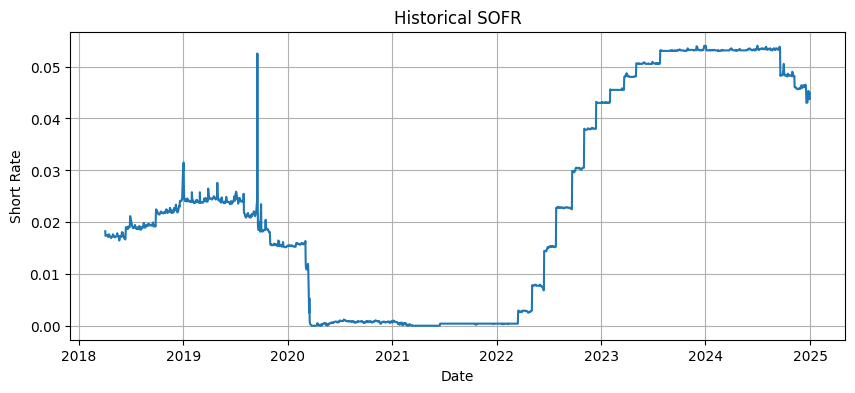

In [14]:
# Create a new matplotlib.pyplot figure, figsize gives the x and y axis size 
plt.figure(figsize=(10, 4))

# Tell matplotlib what data should be fed in to the created figure (if plt.figure was not specified this would create a figure alternatively)
plt.plot(df_SOFR.index, df_SOFR["rate_pct"], label="Historical SOFR")

# Display a grid for better overview
plt.grid()

# Give the figure x and y axis labels
plt.xlabel("Date")
plt.ylabel("Short Rate")

# Define the title
plt.title("Historical SOFR")

# Display the figure object
plt.show()

We observe more activity and less time periods with constant rates produced by the forward fill like before, however we observe a very suspicious spike between 2019 and 2020. To get more information about it and if it is a mistake in the data or a correct value, we have to find the exact date (here index) corresponding to that value. Since this dataframe is not very big we could search it manually in the csv file, we know where it is roughly. However this is not a good procedure for larger datasets with more columns. We could instead look at the change (difference) between each time step. Since it is obvious that this is the largest spike by far, finding the date with the biggest difference to the previous date should give us the date of this jump. We do this by creating a new column that contains the exact same values but shifted forward by one day. Luckily, there is a pandas.DataFrame method for that already : <u><code>.shift()</code></u>. We can then conveniently add or subtract columns from each other (provided they contain compatible datatypes which is the case here).

In [15]:
# Create new column for shifted date:
df_SOFR["rate_pct_shifted"] = df_SOFR["rate_pct"].shift(1) # This will shift forward

# Create difference column:
df_SOFR["diff"] = df_SOFR["rate_pct"] - df_SOFR["rate_pct_shifted"]

# Fill NaN's with 0 (only the first row as we shifted forward, there is no previous day so this created a NaN)
df_SOFR = df_SOFR.fillna(0.0)

In [16]:
# Take a quick look at what we have now:
df_SOFR.head()

,rate_pct,rate_pct_shifted,diff
date,,,
2018-04-03,0.0183,0.0000,0.0000
2018-04-04,0.0174,0.0183,-0.0009
2018-04-05,0.0175,0.0174,0.0001
2018-04-06,0.0175,0.0175,0.0000
2018-04-09,0.0175,0.0175,0.0000


We now got the two new columns we want. Now we have to find the maximum value of the "diff" column.

In [17]:
# Get the maximum easily
max(df_SOFR["diff"])

0.0282

However we are actually interested in the index of that corresponding row this maximum is in. An efficient way would be to use the <u><code>idxmax()</code></u> method that returns the indeces for which each column attains its maximum value.

In [18]:
df_SOFR.idxmax()

rate_pct           2023-12-28
rate_pct_shifted   2023-12-29
diff               2019-09-17
dtype: datetime64[ns]

Now we have the date, it's the 17th September of 2019. A quick online search gives us the information we need, this is not an error in the data but a resulting value from a prominent event. More information can be gathered here:

https://en.wikipedia.org/wiki/September_2019_events_in_the_U.S._repo_market

In [19]:
# Get rid of the two columns again:
del df_SOFR["rate_pct_shifted"], df_SOFR["diff"]

Now extract the first date of the __SOFR__ dataset to get rid of all values after that date in the __DFF__ DataFrame.

In [20]:
sofr_date = df_SOFR.index[0]
sofr_date

Timestamp('2018-04-03 00:00:00')

To get rid of data we can use one of the most important features of pandas.DataFrame, the <u><code>.loc[]</code></u> property (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html). This is used for access of rows and columns. Conveniently this can be used with boolean input as well which means we can select data in this DataFrame using conidtions, such as: "select every row, where the index is smaller (comparison of datetime objects!) than a certain date" .

In [1]:
# Select only the rows where the following condition holds:
condition = (df_DFF.index < sofr_date)

# We here select all columns so there is no specific input after the ",": (This is essentially a Subscription primary using an expression list that has been pre-evaluated to booleans.)
df_DFF = df_DFF.loc[condition, ]

df_DFF.tail() # Here we see that all data after the 2018-04-03 is gone

NameError: name 'df_DFF' is not defined

In [22]:
# Combine the SOFR and DFF data into one dataset using pandas.concat
df_SR = pd.concat([df_DFF, df_SOFR],axis=0)

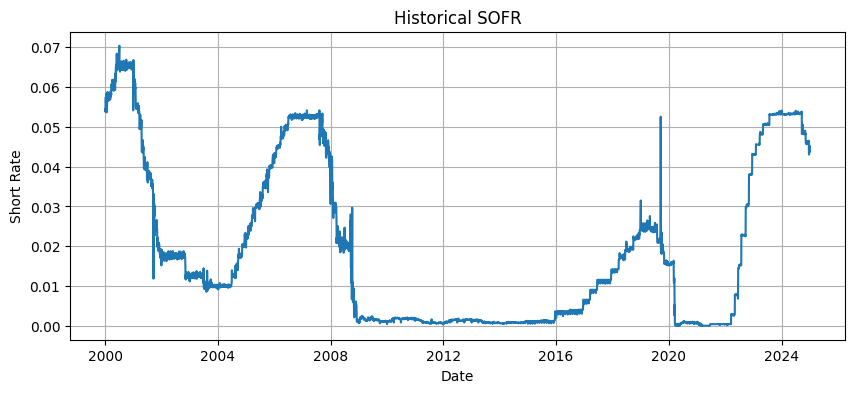

In [23]:
# Once again take a look at the final data:

# Create a new matplotlib.pyplot figure, figsize gives the x and y axis size 
plt.figure(figsize=(10, 4))

# Tell matplotlib what data should be fed in to the created figure (if plt.figure was not specified this would create a figure alternatively)
plt.plot(df_SR.index, df_SR["rate_pct"], label="Historical SOFR")

# Display a grid for better overview
plt.grid()

# Give the figure x and y axis labels
plt.xlabel("Date")
plt.ylabel("Short Rate")

# Define the title
plt.title("Historical SOFR")

# Display the figure object
plt.show()

In [24]:
# Save the resulting dataset as a csv:
df_SR.to_csv(path_or_buf="../data/processed/SR.csv")

### MLE Implementation

After preparing the short rate dataset(s), we now implement the Maximum Likelihood Estimation of our model as described in the above section on the theory. As a quick reminder: we want to estimate $a,b, \sigma$ which means we can set $\theta = (a,b,\sigma)$.
This means we can explicitly calculate its logarithm

$$ \log f(x_i|x_{i-1}\; ; a,b,\sigma) = -\frac{1}{2}\log(2\pi \nu) - \frac{(x_i - \mu_{i-1})^2}{2\nu}$$
with 
$$ \nu = \frac{\sigma^2}{2a}(1-e^{-2a\Delta t}) \quad \text{and} \quad \mu_{i-1} = x_{i-1} e^{-a\Delta t} + b(1-e^{-a\Delta t}) \; .$$

We can define the log-likelihood function now as a function in Python as well with corresponding inputs. The goal is to minimize it's output using Pythons <u><code>scipy</code></u> package. This will be implemented and explained further after the preparation of the data already mentioned.

In [25]:
# Fast package to handle array wide computations:
import numpy as np # (already imported)
# Import enhanced type checking functionalities for arrays to use as input datatype for observations:
from numpy.typing import NDArray
# Package that we will use for minimization:
import scipy
# Package for data structures and reading/saving data:
import pandas as pd #(already imported)

def NegLLVasicek(params: tuple, r:NDArray[np.float64], dt: float) -> float:
    """ Function that evaluates the negative log-likelihood function specifically in our underlying Vasicek model."""
    # Assign just as we described above
    a, b, sigma = params

    # This term is observed multiple times, compute once for efficiency
    phi = np.exp(-a * dt)

    # Compute variance (independant for r!)
    var = (sigma**2 / (2 * a)) * (1 - phi**2)
    
    # compute conditional means (for the entire array! mu is an array with the conditional means!)
    mu = phi * r[:-1] + (1 - phi) * b
    
    # gaussian log-likelihood (just as term above but taking the sum directly)
    ll = -0.5 * np.sum(np.log(2 * np.pi * var) + ((r[1:] - mu) ** 2) / var)
    return -ll  # negative log-likelihood

As a reminder, we still have all the datasets as pandas.DataFrames in the current scope! We will not read in again and continue working. The corresponding Python file reads in the csv data again. We will fit the parameters for the __SR__ (Short Rate) dataset that we combined earlier. The Python functions in <u><code>../source/fit.py</code></u> execute the entire procedure for all datasets. It contains the same functionalities as described in a bit.

In [38]:
# define day-delta on the basis of which we will simulate the SDE dynamics (discretization step assumed to be average business day per year):
delta = 1 / 252

# Extract the values of the 'data' Dataframe into an array (DataFrame.values returns np.array)
r = df_SR.values
print(type(r))

<class 'numpy.ndarray'>


Our goal is to use <u><code>scipy.optimize.minimize </code></u>. Let us get some information on how to use it. Looking at the documentation the most important inputs that we wil have 
to specify are 

<ul style="font-family: 'Times New Roman', serif; margin-left: 1.2em;">
  <li><code>fun</code> , the python function to be minimized</li>
  <li><code>x_0</code>, the starting value(s) in which we shall minimize, in our case starting values for $a,b,\sigma$</li>
  <li><code>args</code> , additional arguments for us $r$ and $dt$</li>
  <li><code>method</code> , an optimization method that will be used (a lot of choices)</li>
  <li><code>bounds</code> , bounds for the parameters</li>
</ul>

The specification using <code>args</code> allows us to set which inputs are taken every iteration of the optimization algorithm, for us this is $r$ and $dt$ as we optimize over using these
as our observations and additional set parameter, and which function inputs are the ones <code>scipy</code> is supposed to find a minimum over. For the method we will use the so called
__L-BFGS-B__ method that is memory efficient and regularly used in parameter estimation problems just as ours.

In [27]:
# Justification for these bounds are given by the parameter description in the introduction to this model
bnds = [(1e-9, 1), # bounds for a --> a > 0
        (-1, 1), # bounds for b --> either negative or positive both possible
        (1e-9, 1) # bounds for sigma --> sigma > 0
       ]

# We initialize the long term mean parameter with the sample mean and the remaining with realistic parameter choices:
start = np.array([0.5,r.mean(),0.5])

Note that optimization problems in general can be very dependant on the starting values for each parameter. Convergence speed and results can change entirely with initialized parameters. There are approaches using __OLS__ regression for a linearized version of this model to get good guesses for these parameters which will not be employed here for the sake of scope.

In [28]:
# This will return an 'OptimizeResult' object that has multiple attributes that we call later
opt = scipy.optimize.minimize(
    fun=NegLLVasicek, 
    x0=start, 
    args=(r, delta), 
    method="L-BFGS-B", 
    bounds=bnds
)

# opt.success is an attribute that signals if the procedure has run without errors
if not opt.success:
    raise RuntimeError("MLE optimization failed: " + opt.message) #opt contains a message that has information about the optimization procedure if failed

# Multi-assignment from opt.x attribute containing optimization result array + opt.fun gives log-likelihood function value for optimized values
a_mle, b_mle, sigma_mle = opt.x
print(
    "MLE estimates: a = %.6g, b = %.6g, sigma = %.6g, fun-value = %.6g"
    % (a_mle, b_mle, sigma_mle, opt.fun)
)

MLE estimates: a = 0.294484, b = 0.0179596, sigma = 0.0148037, fun-value = -36251.8


We want to import the functions from the source/fit.py file . For this we need to adjust the current PYTHONPATH. (This part i.e. importing from "sibling" directory was supported using CHatGPT! The prompt used was :

"In a Python project directoy, i am working in a jupyter notebook in a subdirectory and want to import functions from a Python file that is saved in a 'neighbour' directory. How would you do this?"

In [29]:
import sys
import os

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

In [32]:
# We now added the path to ../source/ to environment variables so we can import: (no ChatGPT from here on out)
import source.fit as fit

In [33]:
# We now repeat the Fitting procedure for all datasets for comparisons
a_SOFR, b_SOFR, sigma_SOFR,_ = fit.MLEFit(path="../data/processed/SOFR_clean.csv")
a_DFF, b_DFF, sigma_DFF,_ = fit.MLEFit(path="../data/processed/DFF_clean.csv")
a_SR, b_SR, sigma_SR,_ = fit.MLEFit(path="../data/processed/SR.csv")

MLE estimates: a = 0.324064, b = 0.0352923, sigma = 0.0180453, fun-value = -9435.86
MLE estimates: a = 0.214044, b = 0.0172379, sigma = 0.0122466, fun-value = -37487.3
MLE estimates: a = 0.294484, b = 0.0179596, sigma = 0.0148037, fun-value = -36251.8


Now that we have obtained parameter estimates, we want to visualize some process trajectories and get a feeling if these parameters make sense or not. For that we need to be able to simulate the process given a set of parameters.

### Simulation

We now simulate trajectories for solutions of the Ohrnstein Uhlenbeck Process as described above. Assume we want to simulate until time $T$ with $n$ many points in time with equal distance.
If we now use an equally distanced discretization $\{t_1,\dots,t_n \; | \; \text{  s.t.  } \; t_{i+1}-t_i = \frac{T}{n}  =: \Delta t \} $ for $[0,T]$ and want to simulate  $(r_t)_{ 0\leq t \leq T}$ at times $t_i$ we can sample $r_{t_{i+1}}$ given $r_{t_{i}}$ using:

$$ r_{t_{i+1}} | r_{t_{i}} \sim \mathcal{N}\left(r_s e^{-a\Delta t} + b(1-e^{-a\Delta t}) \;, \; \frac{\sigma^2}{2a}(1-e^{-2a\Delta t}) \right) \quad .$$

Since we start the process at $r_0 = 0$ we can iteratively build up the process. In general, if we want to simulate 

$$ x \sim \mathcal{N}(\mu, \sigma^2) $$ 

one could as well calculate

$$ y \sim \mathcal{N}(0,1) \quad , \quad x = \sigma  y + \mu $$.

This means we can simulate $y$ upfront using a <u><code>numpy</code></u> random number generator upfront, and recalculate the mean $\mu$ every step iteratively and perform the calculation above. 
Note that one could generate a normal random variable with the final mean and variance each step (this could turn out to be more efficient) but for the sake of a more understandable structure (and more organized code) we will proceed using the above standard calculation.

In [35]:
# Define a function to calculate the new mean and r_(t_(i+1)) given r_(t_(i)), the parameters (a,b,sigma) and delta t.

def VasicekNormal(
    random_number: float = 0,
    current_r: float = 0,
    a: float = 0.3213874,
    b: float = 0.0172119,
    sigma: float = 0.0122468,
    delta: float = 1.0 / 250,
) -> tuple[float, float, float]:
    """This function takes a random number (more efficient if simulated before, standard normal distribution)
    and transforms it into the next r_(t+1) given r_t (current_r). Since this is a normal distribution as well as shown in the MLE_Fit notebook
    or the report pdf, we can just transform a N(0,1) variable into N(mu, sigma^2) by scaling and translation. The formulas for this are
    according to the report as mentioned. This will be applied for entire arrays even though it only takes single values (made possible by numpy!).
    """

    # Factor that is used often -> more efficient to compute only once
    nu = np.exp(-a * delta)

    # Calculate mean and variance of new normal distribution according to transition density derived above
    mean_new = current_r * nu + b * (1 - nu)
    var = (sigma**2) / (2 * a) * (1 - nu**2)

    # Calculate/sample new r value according to transition density (transform presampled N(0,1) number)
    r_new = np.sqrt(var) * random_number + mean_new

    # Return all possibly interesting data
    return r_new, mean_new, var

This function will be called iteratively (we append the mean and the variance just to have so additional information about the process, if not needed it can be omitted). 

In [49]:
# Amount of points sampled (businessdays per year, T=1 corresponds to 1 year)
n = 252

# Declare numpy array of shape (n,3) (-> n rows and 3 columns)
rates = np.zeros(shape=(n, 3))  # r_s, means, variances

# Initialize a generator that we can call for random numbers. Thats why VasicekNormal already takes a random number!
#   If we would define this inside the function we would re-initialize in a for loop and throw it away after only generating one number:
#     --> too slow, we call it ONCE and generate the values ahead of time. This only works exactly like this in our case because of the nice
#         behaviour of a neat transition density!
ran = np.random.default_rng()

# Call the random number generator for (pseudo)-random normal numbers with standard parameters. We call it ONCE and get n-1 many random values directly!
#    (n-1 since for t=0 we have r_0 = 0 set so there are only n-1 many values left for which we need standard normal values)
r_s = ran.normal(loc=0, scale=1, size=n - 1)

# Generate n-1 many new elements:
for i in range(1, n):
    # Take the previous r_t, the generated random number and parameters and compute the next elements:
    r_new, mean_new, var = VasicekNormal(
        random_number=r_s[i - 1],
        current_r=r[i - 1, 0],
        a=a_SR,
        b=b_SR,
        sigma=sigma_SR,
        delta=delta,
    )
    # print(r_new, mean_new, var) (This was from debugging and getting a feel for it, not needed anymore)
    rates[i, :] = r_new, mean_new, var

# Convert to pandas.DataFrame:
rates_SR = pd.DataFrame(data=rates, columns=["r_t", "mean_t", "var"])

In [50]:
# Take a look at the resulting dataframe: column 1 contains the simulated process trajectories
rates_SR # (this is for the combined SR data)

,r_t,mean_t,var
0,0.000000,0.000000,0.000000e+00
1,0.053309,0.054258,8.686270e-07
2,0.051914,0.053758,8.686270e-07
3,0.053224,0.054058,8.686270e-07
4,0.054006,0.055356,8.686270e-07
...,...,...,...
247,0.064969,0.064246,8.686270e-07
248,0.064710,0.064645,8.686270e-07
249,0.065289,0.065245,8.686270e-07
250,0.065813,0.065744,8.686270e-07


This entire process is given as a function in <u><code>./source/simulation.py</code></u> and will be repeated for __DFF__ and __SOFR__ data.

In [48]:
import source.simulation as sim

In [53]:
rates_DFF = sim.SimulateProcess(a=a_DFF,
                               b=b_DFF,
                               sigma=sigma_DFF,
                               n=n,
                               T=1)
rates_SOFR = sim.SimulateProcess(a=a_SOFR,
                               b=b_SOFR,
                               sigma=sigma_SOFR,
                               n=n,
                               T=1)

In [59]:
print("Simulated trajectory for DFF fitted parameters:\n",rates_DFF)
print("Simulated trajectory for SOFR fitted parameters:\n",rates_SOFR)

Simulated trajectory for DFF fitted parameters:
           r_t    mean_t           var
0    0.000000  0.000000  0.000000e+00
1    0.000568  0.000015  5.946523e-07
2    0.002079  0.000582  5.946523e-07
3    0.001115  0.002091  5.946523e-07
4    0.003081  0.001129  5.946523e-07
..        ...       ...           ...
247 -0.003523 -0.002345  5.946523e-07
248 -0.002123 -0.003505  5.946523e-07
249 -0.001039 -0.002107  5.946523e-07
250 -0.000311 -0.001024  5.946523e-07
251 -0.001558 -0.000296  5.946523e-07

[252 rows x 3 columns]
Simulated trajectory for SOFR fitted parameters:
           r_t    mean_t       var
0    0.000000  0.000000  0.000000
1   -0.001142  0.000045  0.000001
2   -0.001729 -0.001095  0.000001
3   -0.003648 -0.001682  0.000001
4   -0.003294 -0.003598  0.000001
..        ...       ...       ...
247  0.008537  0.009551  0.000001
248  0.009473  0.008572  0.000001
249  0.008982  0.009507  0.000001
250  0.009209  0.009016  0.000001
251  0.008066  0.009243  0.000001

[252 rows x 

## Visualization

All of the plots we do here inline, can be called in the <u><code>../source/visualization.py</code></u> file where the plots are created and then saved to 
<u><code>../data/DATASET/list_of_plots.png</code></u>

### Random Trajectories

Let's first plot the trajectories that we can sample now! <u><code>simulation.py</code></u> contains the function <u><code>SimulateTrajectories</code></u> does the same thing we did above, but directly multiple paths as an input parameter and as a consequence does not track the evolving mean anymore.

In [62]:
# This function is essentially the same as we did before just in a for loop (i in range(paths):)
T=1.0
paths = 10

# Get trajectories:

# Combined Short Rate (SR)
r_SR = sim.SimulateTrajectories(a=a_SR,
                        b=b_SR,
                        sigma=sigma_SR,
                        T=T,
                        n=n,
                        paths=paths)
# SOFR
r_SOFR = sim.SimulateTrajectories(a=a_SOFR,
                        b=b_SOFR,
                        sigma=sigma_SOFR,
                        T=T,
                        n=n,
                        paths=paths)
# DFF
r_DFF = sim.SimulateTrajectories(a=a_DFF,
                        b=b_DFF,
                        sigma=sigma_DFF,
                        T=T,
                        n=n,
                        paths=paths)

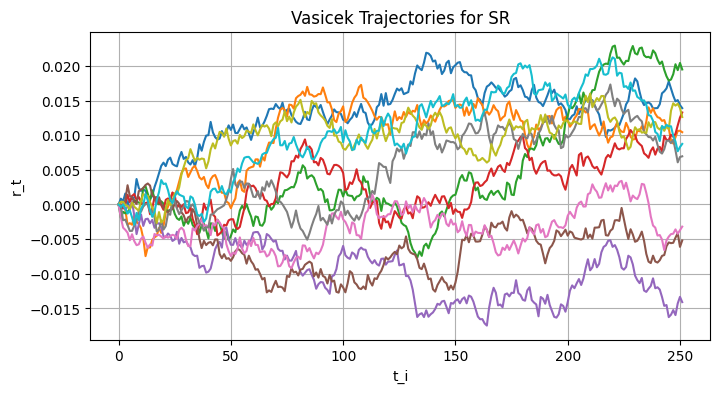

In [69]:
plt.figure(figsize=(8, 4))
plt.plot(r_SR, label="Vasicek Trajectories")
plt.xlabel("t_i")
plt.ylabel("r_t")
plt.title("Vasicek Trajectories for SR")
plt.grid(True)
plt.show()

# --> call .source/visualization/PlotVasicekRandom() alternatively

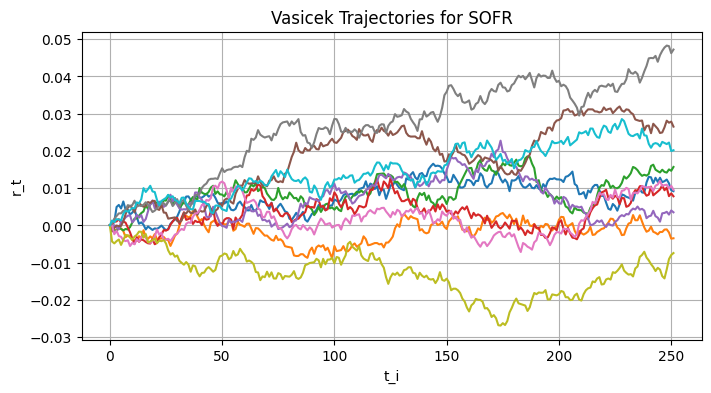

In [71]:
plt.figure(figsize=(8, 4))
plt.plot(r_SOFR, label="Vasicek Trajectories")
plt.xlabel("t_i")
plt.ylabel("r_t")
plt.title("Vasicek Trajectories for SOFR")
plt.grid(True)
plt.show()

# --> call .source/visualization/PlotVasicekRandom() alternatively

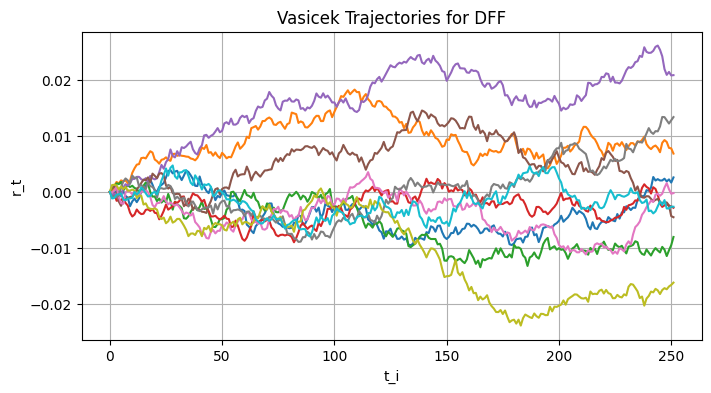

In [70]:
plt.figure(figsize=(8, 4))
plt.plot(r_DFF, label="Vasicek Trajectories")
plt.xlabel("t_i")
plt.ylabel("r_t")
plt.title("Vasicek Trajectories for DFF")
plt.grid(True)
plt.show()

# --> call .source/visualization/PlotVasicekRandom() alternatively

### Deterministic vs History

### Simulation vs History

## Further Remarks and possible Improvements